## Extra

Decidimos no parar aquí y explorar con problemas más dificiles, el primer paso que se nos ocurre es el bipedal-walker, esto trae algunos desafios, como un espacio de acciones continuo, lo que nos lleva a explorar otro métodos ya que el Deep Q learning no abarca este caso.

### Método Actor-Critic

El  método Actor-Critic es de nuevo para espacios discretos, se basa en tener una red que prediga que acción tomar y una red que estima el valor de ese estado, el actor tiene tantas neuronas de salida como acciones a tomar, por lo que sacará una probabilidad de tomar cada una de ellas y el error se calculará en base a esa probabilidad, para hacer su conversión a continuo en este caso actor obtiene como salidas mu y sigma para establecer distribuciones de probabilidad normales con las que se calculará la salida de cada elemento del vector continuo de salida, además las redes critic y actor compartirán inputs y estado oculto, la red nos devolverá una acción y el valor del estado.

La perdida para el actor es la diferencia de la recompensa de una acción y el valor que el critic le ha dado a ese estado en negativo, de forma que si en un estado "malo" se ha conseguido una buena recompensa el loss será bajo, ponderado por la probabilidad de que esa acción se haya llevado a cabo.

Para el caso de el critic la pérdida se corresponde con el huber loss entre la recompensa obtenida y el valor predicho.

Desafortunadamente no funciona con Bipedal, decidimos que es una tarea muy compleja por lo que en primera instancia evaluaremos los modelos continuos con un problema más sencillo (Pendulum-v1), la recompensa más grande posible es 0

Para la implementación nos basamos en la versión discreta de [keras](https://keras.io/examples/rl/actor_critic_cartpole/), modificandola para hacerla continua.

In [ ]:
! pip install tensorflow_probability

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_probability import distributions as tfd
import gymnasium as gym
input_dims = 3
num_outputs = 1
num_hidden = 256
max_steps_per_episode = 200

initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=2, seed=None)

inputs = layers.Input(shape = (input_dims,))
common = layers.Dense(num_hidden, kernel_initializer = initializer, activation="relu")(inputs)
actor = layers.Dense(100, kernel_initializer = initializer, activation = "relu")(common)
mu = layers.Dense(num_outputs, kernel_initializer = initializer, activation="linear")(actor)
sigma = layers.Dense(num_outputs, kernel_initializer = initializer, activation="softplus")(actor)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[mu, sigma, critic])

c:\Users\marco\miniconda3\envs\tensorflow\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [4]:
env = gym.make('Pendulum-v1', g=9.81)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0
gamma = 0.99
eps = 1e-7
min_action = -2.0
max_action = 2.0


while True:  # Run until solved
    state, _ = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            mu, sigma, critic_value = model(state)
            
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            distrib = tfd.Normal(mu, sigma + eps)
            action = distrib.sample(1)
            action_probs_history.append(tf.math.log(distrib.prob(action)[0,0]))
            action = tf.clip_by_value(action, min_action, max_action)

            # Apply the sampled action in our environment
            state, reward, terminated, truncated, info = env.step(action[0,0])
            rewards_history.append(reward)
            episode_reward += reward
            
            if terminated or truncated:
                break
            
        episode_reward = -10/episode_reward
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
            
        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()
        
        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        
    episode_count += 1
    if episode_count % 20 == 0:
        template = "running reward: {:.4f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 0.05:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

In [8]:
env = gym.make('Pendulum-v1', g=9.81, render_mode='human')

state, _ = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    # Seleccionamos una acción dado el actual estado ...
    mu, sigma, critic_value = model(state)
            

    # Sample action from action probability distribution
    distrib = tfd.Normal(mu, sigma + eps)
    action = distrib.sample(1)
    action = tf.clip_by_value(action, min_action, max_action)
    # ... y la ejecutamos, obteniendo el nuevo estado
    state, _, terminated, truncated, _ = env.step(action[0,0])
env.close()

Tampoco conseguimos ningún resultado, probamos métodos con los que obtener que acción tomar directamente

## Deep-Determistic Double Policy Gradient Descent (DDPG)

En vez de tener una red que para un estado nos sugiera unos valores para las distintas acciones a tomar, con este método se tienen 2 redes, 1 de ellas (actor) para un estado nos dirá que acción tomar, la otra (critic) nos dirá para un estado dado y una acción su valor.

De forma que para el actor la función de perdida será para un batch la media de los valores dados por el critic para sus acciones en el estado en el cual se tomaron, en negativo para que se intente reducir, haciendo así que el actor intente crear un reward siempre más alto cada vez.

Para el critic la función de perdida será la diferencia entre las rewards reales y los valores dados para un batch por la red.

En nuestro caso para evitar sesgo hemos decidido el uso de 2 redes para actor y 2 para critic, a la hora de obtener los errores se hace con esas redes llamadas target.

Implementación basada en el ejemplo de [keras](https://keras.io/examples/rl/ddpg_pendulum/)

In [10]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [19]:
problem = "Pendulum-v1"
env = gym.make(problem, render_mode=None)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [20]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [21]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [22]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [23]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [24]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -1293.4101776294704
Episode * 1 * Avg Reward is ==> -1329.6265041344936
Episode * 2 * Avg Reward is ==> -1420.554083113812
Episode * 3 * Avg Reward is ==> -1454.9406900832041
Episode * 4 * Avg Reward is ==> -1463.5719055886213
Episode * 5 * Avg Reward is ==> -1455.798814408731
Episode * 6 * Avg Reward is ==> -1461.072829411661
Episode * 7 * Avg Reward is ==> -1460.9723353534391
Episode * 8 * Avg Reward is ==> -1430.3307608529828
Episode * 9 * Avg Reward is ==> -1397.9776715729815
Episode * 10 * Avg Reward is ==> -1408.3918073347088
Episode * 11 * Avg Reward is ==> -1394.060549972535
Episode * 12 * Avg Reward is ==> -1355.3877672619622
Episode * 13 * Avg Reward is ==> -1286.1721813407862
Episode * 14 * Avg Reward is ==> -1241.182665881549
Episode * 15 * Avg Reward is ==> -1231.4853472668565
Episode * 16 * Avg Reward is ==> -1197.5137781207616
Episode * 17 * Avg Reward is ==> -1169.5608511474143
Episode * 18 * Avg Reward is ==> -1141.9663887691513
Episode 

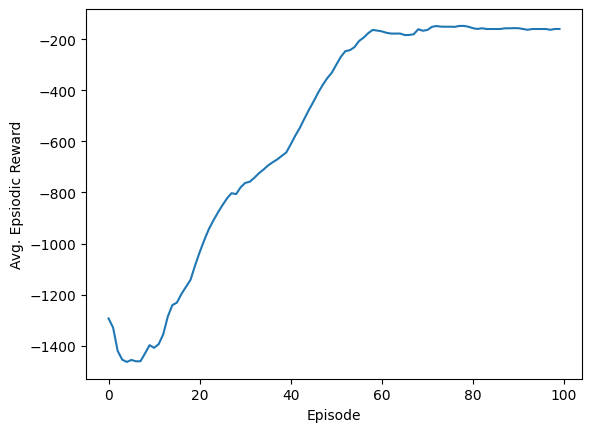

In [25]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state,_ = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, truncated, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [27]:
env = gym.make('Pendulum-v1', g=9.81, render_mode='human')

state, _ = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    state = tf.expand_dims(tf.convert_to_tensor(state), 0)
    action = policy(state, ou_noise)
    # ... y la ejecutamos, obteniendo el nuevo estado
    state, _, terminated, truncated, _ = env.step(action)
env.close()

Hemos conseguido resolver el problema, probamos con Bipedal

In [54]:
problem = "BipedalWalker-v3"
env = gym.make(problem, render_mode=None)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  24
Size of Action Space ->  4
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [55]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [56]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    model = tf.keras.Model(inputs, outputs)
    return model

In [57]:
std_dev = 1
ou_noise = OUActionNoise(mean=np.zeros(num_actions), std_deviation=float(std_dev) * np.ones(num_actions))
dec_std = 0.995
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 1024)

Episode * 0 * Avg Reward is ==> -134.21310052997802
Episode * 20 * Avg Reward is ==> -123.80102633456609
Episode * 40 * Avg Reward is ==> -118.74134926108552
Episode * 60 * Avg Reward is ==> -114.16909518692883
Episode * 80 * Avg Reward is ==> -115.2518519653928
Episode * 100 * Avg Reward is ==> -115.16313131638165
Episode * 120 * Avg Reward is ==> -112.84694430313498
Episode * 140 * Avg Reward is ==> -124.70551091701422
Episode * 160 * Avg Reward is ==> -115.33162676495627
Episode * 180 * Avg Reward is ==> -112.73695529390211
Episode * 200 * Avg Reward is ==> -142.11156138305867
Episode * 220 * Avg Reward is ==> -125.88396748482944
Episode * 240 * Avg Reward is ==> -130.0119467621896
Episode * 260 * Avg Reward is ==> -114.86385918332034
Episode * 280 * Avg Reward is ==> -117.25151999838764
Episode * 300 * Avg Reward is ==> -114.26612042745974
Episode * 320 * Avg Reward is ==> -119.41100968827932
Episode * 340 * Avg Reward is ==> -115.48344268586752
Episode * 360 * Avg Reward is ==> -1

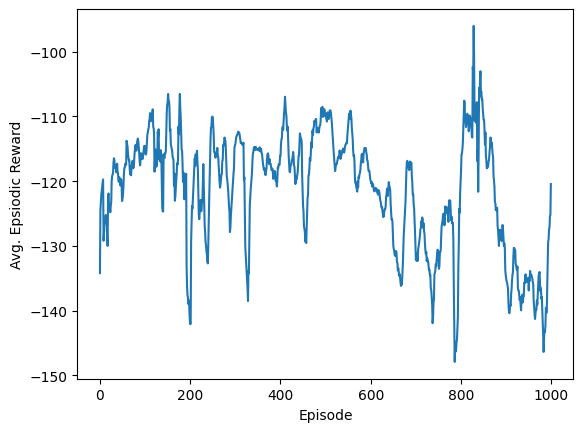

In [59]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state,_ = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, truncated, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    if ep % 20 == 0:
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    if ou_noise.std_dev[0] > 0.05:
        ou_noise.std_dev = ou_noise.std_dev * 0.995

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

Aunque no conseguimos que funcione con Bipedal, hemos dado un paso adelante pudiendo implementar un modelo que sirva para  entornos continuos de acciones, a continuación haremos una implementación híbrida entre la dada por el profesor y DDPG.

In [83]:
class ContAgent:
    
    def __init__(
        self, *,
        env: gym.Env,
        critic_model: Union[Callable[[int, int], tf.keras.Model], tf.keras.Model, str],
        actor_model: Union[Callable[[int, int], tf.keras.Model], tf.keras.Model, str],
        actor_optimizer: tf.keras.optimizers.Optimizer,
        critic_optimizer: tf.keras.optimizers.Optimizer,
        batch_size=64,
        memory_size: int = 5* (1e5),
        gamma=0.99,
        tau=0.005
        
    ):
        """Inicializa el objeto.
        :param model: El modelo del objeto. Puede ser una función que devuelva
            un nuevo modelo (compilado), un objeto de `tf.keras.Model` ya
            existente (en cuyo caso se clonará) o una cadena con un path
            válido, en cuyo caso se cargará de disco.
        """
        # El entorno en el que vamos a trabajar
        self.env = env
        self.num_inputs = env.observation_space.shape[0]
        self.num_outputs = env.action_space.shape[0]
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]

        # Definimos lo modelos
        if callable(critic_model):
            self.critic_model = critic_model(
                self.num_inputs,
                self.num_outputs,
            )
        elif isinstance(critic_model, tf.keras.models.Model):
            self.critic_model = critic_model
        elif isinstance(critic_model, str):
            self.critic_model = tf.keras.models.load_model(critic_model)
        else:
            raise ValueError('Valid models are a function, a model or a path')
        
        if callable(actor_model):
            self.actor_model = actor_model(
                self.num_inputs,
                self.num_outputs,
                self.upper_bound
            )
        elif isinstance(actor_model, tf.keras.models.Model):
            self.actor_model = actor_model
        elif isinstance(actor_model, str):
            self.actor_model = tf.keras.models.load_model(actor_model)
        else:
            raise ValueError('Valid models are a function, a model or a path')
        
        self.target_cmodel = tf.keras.models.clone_model(self.critic_model)
        self.target_amodel = tf.keras.models.clone_model(self.actor_model)
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer

        self.batch_size = batch_size
        
        self.gamma = gamma
        # En que medida se actualizan los pesos de las redes target
        self.tau = tau

        self.memory = Memory(size=memory_size)

        # El estado del entorno en el que se encuentra el agente
        self.current_state = None
        # El número de paso en la tarea en la que se encuentra el agente
        self.current_step = 0

    def episode(self, epsilon=0, max_iterations=None):
        max_iterations = max_iterations or np.inf

        self.current_state, _ = self.env.reset()
        self.current_step = 0

        reward = 0
        running = True
        while running and self.current_step < max_iterations:
            self.current_step += 1

            perception = self.perceive()
            action = self.decide(perception, epsilon)
            transition = self.act(action)
            self.learn()

            reward += transition.reward
            running = not transition.terminated

        return reward

    def perceive(self):
        return self.current_state
        
    def decide(self, perception, epsilon=0):
        if np.random.rand() < epsilon:
            return np.random.uniform(low=self.lower_bound, high=self.upper_bound,size=self.num_outputs)
        else:
            perception = perception[np.newaxis, ...]
            action = tf.squeeze(self.actor_model(perception)).numpy()
            action = np.clip(action, self.lower_bound, self.upper_bound)
            return [np.squeeze(action)]
    
    def act(self, action):
        # Ejecutamos la acción sobre el entorno
        next_state, reward, terminated, truncated, info = self.env.step(action)

        # Guardamos en la memoria del agente la transición realizada junto con
        # su información
        self.memory.remember(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))
        
        # Indicamos el nuevo estado en el que se encuentra el agente ahora
        self.current_state = next_state
        
        return self.memory[-1]
    
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Calculamos la perdida de crtic
        with tf.GradientTape() as tape:
            # Sacamos las acciones que se deberáin haber tomado para cada estado en el batch
            target_actions = self.target_amodel(next_state_batch, training=True)
            # Obtenemos la recompensa real de las acciones más el valor de las acciones futuras
            y = reward_batch + self.gamma * self.target_cmodel(
                [next_state_batch, target_actions], training=True
            )
            # Obtenemos los valores que el critic ha dado
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            # Obtenemos la distancia
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        # Obtenemos los gradientes
        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        # Aplicamos los gradientes
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )
        # Calculamos la perdida de actor
        with tf.GradientTape() as tape:
            # Sacamos las acciones que se deberáin haber tomado para cada estado en el batch
            actions = self.actor_model(state_batch, training=True)
            # Obtenemos los valores que el critic le da a esas acciones
            critic_value = self.critic_model([state_batch, actions], training=True)
            # Obtnemos la perdida
            actor_loss = -tf.math.reduce_mean(critic_value)

        # Obtenemos los gradientes
        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # Aplicamos los gradientes
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )
        
        # Actualizamos los pesos de las redes target, usando el parametro tau como proporción
        for (a, b) in zip([self.target_amodel.weights, self.target_cmodel.weights], [self.actor_model.weights, self.critic_model.weights]):
            a[0].assign(b[0] * self.tau + a[0] * (1 - self.tau))
            a[1].assign(b[1] * self.tau + a[1] * (1 - self.tau))

    def learn(self):
        # Entrenamos en batch
        if len(self.memory) > self.batch_size:
            transactions = self.memory.batch(self.batch_size)
            
            prev_states = tf.convert_to_tensor([t.prev_state for t in transactions])
            next_states = tf.convert_to_tensor([t.next_state for t in transactions])
            actions = tf.convert_to_tensor([t.action for t in transactions])
            rewards = tf.convert_to_tensor([t.reward for t in transactions])
            rewards = tf.cast(rewards, dtype=tf.float32)

            self.update(prev_states, actions, rewards, next_states)  

In [84]:
def get_actor(num_states, num_actions, upper_bound):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = tf.keras.layers.Input(shape=(num_states,))
    out = tf.keras.layers.Dense(256, activation="relu")(inputs)
    out = tf.keras.layers.Dense(256, activation="relu")(out)
    outputs = tf.keras.layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic(num_states, num_actions):
    # State as input
    state_input = tf.keras.layers.Input(shape=(num_states))
    state_out = tf.keras.layers.Dense(16, activation="relu")(state_input)
    state_out = tf.keras.layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = tf.keras.layers.Input(shape=(num_actions))
    action_out = tf.keras.layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = tf.keras.layers.Concatenate()([state_out, action_out])

    out = tf.keras.layers.Dense(256, activation="relu")(concat)
    out = tf.keras.layers.Dense(256, activation="relu")(out)
    outputs = tf.keras.layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [87]:
problem = "Pendulum-v1"
env = gym.make(problem, render_mode=None)

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)



agente = ContAgent(env=env, critic_model=get_critic, actor_model=get_actor, actor_optimizer=actor_optimizer, critic_optimizer=critic_optimizer)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
NUMBER_OF_EPISODES = 1000
MAX_STEPS = 200

RUNNING_AVG_WINDOW_SIZE = 10

MAX_EPSILON = 1
MIN_EPSILON = 0
DEC_EPSILON = 0.95

rewards = []
rewards_avg = []
epsilon = MAX_EPSILON
for episode in range(NUMBER_OF_EPISODES):
    # Reseteamos el entorno y el agente para comenzar un nuevo episodio
    reward = agente.episode(epsilon, MAX_STEPS)

    # Salvamos el modelo
    agente.critic_model.save(f'tmp/critic_{problem}.h5')
    agente.actor_model.save(f'tmp/actor_{problem}.h5')

    # Actualizamos el histórico de valores
    rewards.append(reward)
    rewards_avg.append(np.mean(rewards[-RUNNING_AVG_WINDOW_SIZE:]))
    if reward >= -10:
        agente.critic_model.save(f'tmp/{reward}_{episode}critic_{problem}.h5')
        agente.actor_model.save(f'tmp/{reward}_{episode}actor_{problem}.h5')
    # Imprimimos un mensaje
    print(f'Episode: {episode}, reward: {reward:5.4f} (best: {max(rewards):5.4f}, avg. window: {rewards_avg[-1]:5.4f})', end='\r')

    # Disminuimos 𝜀 para reducir la aletoriedad de la selección de acción
    epsilon *= DEC_EPSILON
    epsilon = max(MIN_EPSILON, epsilon)
    
    # Clear de la sesión porque con fit y predict se quedan nodos del grafo
    # referenciados en memoria que nunca se limpian y, por tanto, me consumen
    # toda la memoria después de bastantes vueltas del bucle.
    #tf.keras.backend.clear_session()
    if rewards_avg[-1] >= -2 and len(rewards)>RUNNING_AVG_WINDOW_SIZE:
        break

Sin embargo nuestra propia implementación híbrida no aprende, no es por el ruido, por falta de tiempo debido a los exámenes finales no hemos descubierto el fallo ni continuado nuestra exploración, nuestra siguiente apuesta era Proximal Policy Optimization (PPO).